# ОИАД. Лабораторная работа №3 — Многомерная линейная регрессия, регуляризация, оценка качества

Датасет: `insurance.csv` (лежит в папке с проектом).

Задачи:
1. Подготовка данных: пропуски, выбросы, кодирование категориальных, корреляции.
2. Многомерная линейная регрессия: аналитическое решение и численное (градиентный спуск) — реализовать самостоятельно.
3. Добавление регуляризации: гребневая регрессия (Ridge) — аналитическое и численное решение; дополнительно покажем LASSO (только численно).
4. Оценка обобщающей способности: сравнить по MSE на тестовой выборке:
   - константная модель (прогноз средним значением);
   - модель без регуляризации;
   - модель с регуляризацией.

Разрешённые библиотеки: `numpy`, `pandas`, `matplotlib`, а также базовые утилиты из `scikit-learn` (например, `train_test_split`, `StandardScaler`) для разбиения и масштабирования. Все регрессионные алгоритмы реализуем вручную (без `LinearRegression`, `Ridge` и т.п.).

## Теоретическое напоминание

### Типы признаков и их кодирование

- **Количественные/непрерывные** — много различных числовых значений (возраст, рост, зарплата).
- **Бинарные** — два значения (пол: male/female, smoker: yes/no). Кодируем 0/1.
- **Категориальные/номинальные** — конечное число значений без естественного порядка (region: northwest/southeast/...). Кодируем one-hot (dummy-переменными).
- **Порядковые/ранговые** — значения можно упорядочить (степень тяжести, уровень образования). Можно закодировать числами, сохраняя порядок.

### Многомерная линейная регрессия

Матрица объектов-признаков $X$ размера $\ell \times n$ (\(\ell\) — число объектов, \(n\) — число признаков, включая константу). Вектор параметров модели $w$ — размера $n$.

Модель:
$$ f(x, w) = w^T x = X w. $$

Функционал квадратичных потерь (SSE, сумма квадратов ошибок):
$$ Q(w) = \sum_{i=1}^{\ell} (f(x_i, w) - y_i)^2 = \|Xw - y\|^2. $$

Градиент:
$$ \frac{\partial Q}{\partial w} = 2 X^T (Xw - y). $$

#### Аналитическое решение (нормальные уравнения)
Приравниваем градиент к нулю:
$$ 2 X^T (Xw - y) = 0 \Rightarrow X^T X w = X^T y. $$
Если матрица $X^T X$ обратима:
$$ w^* = (X^T X)^{-1} X^T y. $$
Проблемы возникают при сильной мультиколлинеарности (признаки линейно зависимы) — $X^T X$ плохо обусловлена или необратима.

#### Численное решение (градиентный спуск)
Итерационный метод:
$$ w^{(k+1)} = w^{(k)} - \lambda \cdot \nabla Q(w^{(k)}), $$
где \(\lambda\) — шаг градиентного спуска. Останавливаемся, когда изменение $w$ мало, градиент мал или достигнут лимит по итерациям.

### Регуляризация

Чтобы бороться с неустойчивыми весами при мультиколлинеарности, добавляем штраф на норму весов.

- **Гребневая регрессия (Ridge, L2):**
$$ Q_{L_2}(w) = \|Xw - y\|^2 + \alpha \|w\|_2^2. $$
Аналитическое решение:
$$ w^* = (X^T X + \alpha I)^{-1} X^T y. $$

- **LASSO (L1):**
$$ Q_{L_1}(w) = \|Xw - y\|^2 + \beta \|w\|_1. $$
Аналитического решения нет, используем численные методы (например, координатный спуск).

### Оценка обобщающей способности
Разделяем данные на train/test:
- обучающая выборка — подбираем параметры модели;
- тестовая выборка — оцениваем качество (например, по MSE).

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 140)

plt.rcParams['figure.figsize'] = (6, 4)
plt.rcParams['axes.grid'] = True

## 1. Подготовка данных

Шаги:
1. Загрузить датасет `insurance.csv`.
2. Проверить наличие пропусков и выбросов.
3. Преобразовать категориальные признаки в численные (sex, smoker, region).
4. Вычислить парные корреляции признаков и целевой переменной `charges`.

In [2]:
# Загрузка датасета (локальный файл insurance.csv)
file_path = 'insurance.csv'
if not os.path.exists(file_path):
    raise FileNotFoundError('Файл insurance.csv не найден в текущей директории.')

df = pd.read_csv(file_path)
print('Размерность данных:', df.shape)
display(df.head())
display(df.info())
display(df.describe(include='all'))

Размерность данных: (1338, 7)


,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


None

,age,sex,bmi,children,smoker,region,charges
count,1338.000000,1338,1338.000000,1338.000000,1338,1338,1338.000000
unique,NaN,2,NaN,NaN,2,4,NaN
top,NaN,male,NaN,NaN,no,southeast,NaN
freq,NaN,676,NaN,NaN,1064,364,NaN
mean,39.207025,NaN,30.663397,1.094918,NaN,NaN,13270.422265
std,14.049960,NaN,6.098187,1.205493,NaN,NaN,12110.011237
min,18.000000,NaN,15.960000,0.000000,NaN,NaN,1121.873900
25%,27.000000,NaN,26.296250,0.000000,NaN,NaN,4740.287150
50%,39.000000,NaN,30.400000,1.000000,NaN,NaN,9382.033000
75%,51.000000,NaN,34.693750,2.000000,NaN,NaN,16639.912515


In [3]:
# Проверка пропусков и дубликатов
print('Число пропусков по столбцам:')
print(df.isna().sum())
print('\nЧисло дубликатов строк:', df.duplicated().sum())

# Поиск выбросов для числовых признаков по IQR
num_cols = ['age', 'bmi', 'children', 'charges']
outlier_summary = []
for col in num_cols:
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    mask_out = (df[col] < lower) | (df[col] > upper)
    outlier_count = int(mask_out.sum())
    outlier_summary.append((col, outlier_count, lower, upper))

print('\nВыбросы по IQR (колонка, количество, нижняя граница, верхняя граница):')
for item in outlier_summary:
    print(item)

print('\nВ этой лабораторной выбросы учитываем, но не удаляем автоматически.')

Число пропусков по столбцам:
age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

Число дубликатов строк: 1

Выбросы по IQR (колонка, количество, нижняя граница, верхняя граница):
('age', 0, np.float64(-9.0), np.float64(87.0))
('bmi', 9, np.float64(13.7), np.float64(47.290000000000006))
('children', 0, np.float64(-3.0), np.float64(5.0))
('charges', 139, np.float64(-13109.1508975), np.float64(34489.350562499996))

В этой лабораторной выбросы учитываем, но не удаляем автоматически.


### Кодирование категориальных признаков

- `sex`: female/male → 0/1
- `smoker`: no/yes → 0/1
- `region`: southwest/southeast/northwest/northeast → one-hot (drop_first=True, чтобы избежать мультиколлинеарности вместе с константой).

In [4]:
df_proc = df.copy()

# Бинарные признаки
df_proc['sex'] = df_proc['sex'].map({'female': 0, 'male': 1})
df_proc['smoker'] = df_proc['smoker'].map({'no': 0, 'yes': 1})

# One-hot для region (drop_first=True)
df_proc = pd.get_dummies(df_proc, columns=['region'], drop_first=True)

print('Столбцы после кодирования категориальных признаков:')
print(list(df_proc.columns))
display(df_proc.head())
display(df_proc.describe(include='all'))

Столбцы после кодирования категориальных признаков:
['age', 'sex', 'bmi', 'children', 'smoker', 'charges', 'region_northwest', 'region_southeast', 'region_southwest']


,age,sex,bmi,children,smoker,charges,region_northwest,region_southeast,region_southwest
0,19,0,27.900,0,1,16884.92400,False,False,True
1,18,1,33.770,1,0,1725.55230,False,True,False
2,28,1,33.000,3,0,4449.46200,False,True,False
3,33,1,22.705,0,0,21984.47061,True,False,False
4,32,1,28.880,0,0,3866.85520,True,False,False


,age,sex,bmi,children,smoker,charges,region_northwest,region_southeast,region_southwest
count,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338,1338,1338
unique,NaN,NaN,NaN,NaN,NaN,NaN,2,2,2
top,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False
freq,NaN,NaN,NaN,NaN,NaN,NaN,1013,974,1013
mean,39.207025,0.505232,30.663397,1.094918,0.204783,13270.422265,NaN,NaN,NaN
std,14.049960,0.500160,6.098187,1.205493,0.403694,12110.011237,NaN,NaN,NaN
min,18.000000,0.000000,15.960000,0.000000,0.000000,1121.873900,NaN,NaN,NaN
25%,27.000000,0.000000,26.296250,0.000000,0.000000,4740.287150,NaN,NaN,NaN
50%,39.000000,1.000000,30.400000,1.000000,0.000000,9382.033000,NaN,NaN,NaN
75%,51.000000,1.000000,34.693750,2.000000,0.000000,16639.912515,NaN,NaN,NaN


### Парные корреляции признаков с целевой переменной `charges`

Построим корреляционную матрицу и простую тепловую карту с помощью `matplotlib`.
Также выведем корреляцию каждого признака с целевой переменной по модулю.

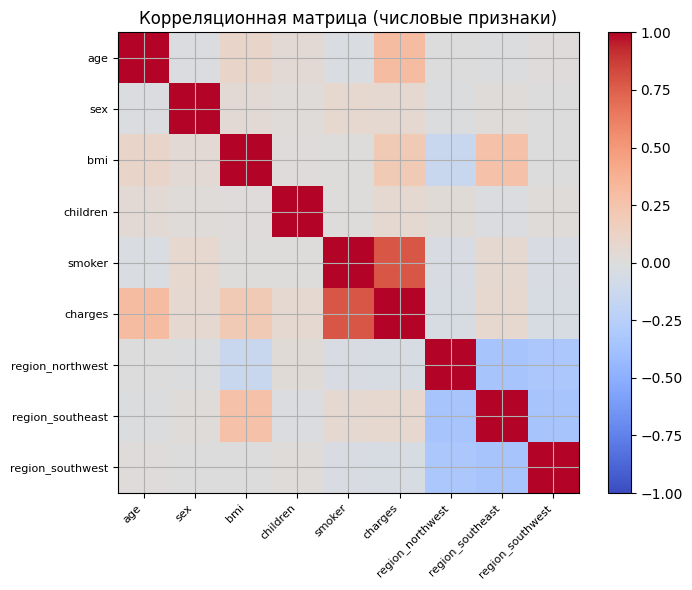

Корреляции с charges (по убыванию абсолютного значения):


,corr_with_charges
smoker,0.787251
age,0.299008
bmi,0.198341
region_southeast,0.073982
children,0.067998
sex,0.057292
region_southwest,-0.043210
region_northwest,-0.039905


In [5]:
corr = df_proc.corr(numeric_only=True)

plt.figure(figsize=(8, 6))
im = plt.imshow(corr.values, cmap='coolwarm', vmin=-1, vmax=1)
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.xticks(range(len(corr.columns)), corr.columns, rotation=45, ha='right', fontsize=8)
plt.yticks(range(len(corr.index)), corr.index, fontsize=8)
plt.title('Корреляционная матрица (числовые признаки)')
plt.tight_layout()
plt.show()

print('Корреляции с charges (по убыванию абсолютного значения):')
target_col = 'charges'
corr_target = corr[target_col].drop(target_col).sort_values(key=lambda s: s.abs(), ascending=False)
display(corr_target.to_frame('corr_with_charges'))

## Разбиение на train/test и масштабирование признаков

Для оценки обобщающей способности разобьём данные на:
- **train** — 80%;
- **test** — 20%.

Для стабильной сходимости градиентного спуска масштабируем числовые признаки (age, bmi, children) стандартным масштабированием (0-среднее, 1-ст. отклонение). Бинарные и one-hot признаки (sex, smoker, region_*) оставим как есть.

Также добавим столбец единиц (intercept) в матрицу признаков и **не будем штрафовать его** при регуляризации.

In [6]:
target_col = 'charges'
feature_cols = [c for c in df_proc.columns if c != target_col]

X_full = df_proc[feature_cols].copy()
y_full = df_proc[target_col].values.astype(float)

# Числовые признаки для масштабирования
num_to_scale = ['age', 'bmi', 'children']
bin_and_dummies = [c for c in feature_cols if c not in num_to_scale]

# Разбиение на train/test
X_train_df, X_test_df, y_train, y_test = train_test_split(
    X_full, y_full, test_size=0.2, random_state=RANDOM_STATE
)

# Масштабирование числовых признаков по train и применение к test
scaler = StandardScaler()
X_train_scaled_num = scaler.fit_transform(X_train_df[num_to_scale])
X_test_scaled_num = scaler.transform(X_test_df[num_to_scale])

# Собираем окончательные матрицы признаков
X_train = np.column_stack([X_train_scaled_num, X_train_df[bin_and_dummies].values])
X_test = np.column_stack([X_test_scaled_num, X_test_df[bin_and_dummies].values])

final_feature_names = num_to_scale + bin_and_dummies

print('Train shape (без интерсепта):', X_train.shape)
print('Test shape (без интерсепта):', X_test.shape)
print('Порядок признаков:', final_feature_names)

def add_intercept(X):
    X = np.asarray(X, dtype=float)
    ones = np.ones((X.shape[0], 1), dtype=float)
    return np.hstack([ones, X])

X_train_i = add_intercept(X_train)
X_test_i = add_intercept(X_test)

print('Train shape (с интерсептом):', X_train_i.shape)
print('Test shape (с интерсептом):', X_test_i.shape)
print('Типы данных X_train_i:', X_train_i.dtype)

Train shape (без интерсепта): (1070, 8)
Test shape (без интерсепта): (268, 8)
Порядок признаков: ['age', 'bmi', 'children', 'sex', 'smoker', 'region_northwest', 'region_southeast', 'region_southwest']
Train shape (с интерсептом): (1070, 9)
Test shape (с интерсептом): (268, 9)
Типы данных X_train_i: float64


## Вспомогательные функции

Реализуем:
- MSE и функцию предсказаний;
- аналитическое OLS-решение (через псевдообратную матрицу);
- аналитическое Ridge-решение (L2-регуляризация);
- градиентный спуск для OLS и Ridge (минимизация MSE + L2-штраф);
- LASSO (L1-регуляризация) через координатный спуск (по желанию);
- простое разбиение train/val для подбора регуляризационного параметра.

In [7]:
def mse(y_true, y_pred):
    """Среднеквадратичная ошибка (MSE)."""
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    return float(np.mean((y_true - y_pred) ** 2))

def predict(X, w):
    X = np.asarray(X, dtype=float)
    w = np.asarray(w, dtype=float)
    return X @ w

# 1) OLS аналитически (используем псевдообратную для устойчивости)
def ols_normal_equation(X, y):
    X = np.asarray(X, dtype=float)
    y = np.asarray(y, dtype=float)
    # np.linalg.pinv работает и при мультиколлинеарности
    w = np.linalg.pinv(X) @ y
    return w

# 2) Ridge аналитически (без штрафа на интерсепт)
def ridge_closed_form(X, y, alpha, penalize_intercept=False):
    X = np.asarray(X, dtype=float)
    y = np.asarray(y, dtype=float)
    n_features = X.shape[1]
    A = X.T @ X
    ridge = alpha * np.eye(n_features)
    if not penalize_intercept:
        ridge[0, 0] = 0.0  # не штрафуем первый коэффициент (интерсепт)
    w = np.linalg.solve(A + ridge, X.T @ y)
    return w

# Оценка безопасного шага обучения для MSE (градиент: 2/n X^T (Xw - y))
def safe_lr_ols(X):
    X = np.asarray(X, dtype=float)
    n = X.shape[0]
    s = np.linalg.svd(X, compute_uv=False)
    s_max2 = (s[0] ** 2) if len(s) > 0 else 1.0
    # Липшицев константа L для градиента MSE: L = 2/n * s_max^2
    L = 2.0 / n * s_max2
    return 1.0 / (L + 1e-12)

def safe_lr_ridge(X, l2):
    X = np.asarray(X, dtype=float)
    n = X.shape[0]
    s = np.linalg.svd(X, compute_uv=False)
    s_max2 = (s[0] ** 2) if len(s) > 0 else 1.0
    # Для Ridge: градиент MSE: 2/n X^T e + 2*l2*w → L = 2/n*s_max^2 + 2*l2
    L = 2.0 / n * s_max2 + 2.0 * l2
    return 1.0 / (L + 1e-12)

def gradient_descent(X, y, lr=None, n_epochs=5000, l2=0.0, tol=1e-8, verbose=False):
    """Градиентный спуск для MSE (при l2>0 добавляется L2-регуляризация)."""
    X = np.asarray(X, dtype=float)
    y = np.asarray(y, dtype=float)
    n_samples, n_features = X.shape
    if lr is None:
        lr = safe_lr_ridge(X, l2) if l2 > 0 else safe_lr_ols(X)
        lr *= 0.9  # делаем шаг чуть консервативнее
    w = np.zeros(n_features, dtype=float)
    history = []
    for t in range(n_epochs):
        y_pred = X @ w
        error = y_pred - y
        grad = (2.0 / n_samples) * (X.T @ error)
        if l2 != 0.0:
            reg = 2.0 * l2 * w
            reg[0] = 0.0  # не штрафуем интерсепт
            grad += reg
        w_new = w - lr * grad
        if np.linalg.norm(w_new - w) < tol:
            w = w_new
            if verbose:
                print(f'Early stop at iter {t}, ||dw|| < tol')
            break
        w = w_new
        if (t % 200 == 0) or (t == n_epochs - 1):
            history.append(mse(y, y_pred))
            if verbose:
                print(f'iter={t}, train MSE={history[-1]:.4f}')
    return w, history

# LASSO: координатный спуск (без штрафа на интерсепт)
def soft_threshold(rho, alpha):
    if rho < -alpha:
        return rho + alpha
    elif rho > alpha:
        return rho - alpha
    else:
        return 0.0

def lasso_coordinate_descent(X, y, alpha, n_iters=2000, tol=1e-6, verbose=False):
    X = np.asarray(X, dtype=float)
    y = np.asarray(y, dtype=float)
    n_samples, n_features = X.shape
    w = np.zeros(n_features, dtype=float)
    for it in range(n_iters):
        w_old = w.copy()
        # обновляем интерсепт (без штрафа)
        y_pred = X @ w
        residual = y - y_pred
        w[0] = w[0] + residual.mean()
        # обновляем остальные координаты
        for j in range(1, n_features):
            r = y - (X @ w) + X[:, j] * w[j]
            rho = np.dot(X[:, j], r) / n_samples
            z = np.dot(X[:, j], X[:, j]) / n_samples
            w[j] = soft_threshold(rho, alpha) / (z + 1e-12)
        if np.linalg.norm(w - w_old, ord=1) < tol:
            if verbose:
                print(f'LASSO CD early stop at iter={it}')
            break
    return w

def simple_train_val_split(X, y, val_size=0.2, random_state=RANDOM_STATE):
    X = np.asarray(X, dtype=float)
    y = np.asarray(y, dtype=float)
    n = X.shape[0]
    idx = np.arange(n)
    rng = np.random.RandomState(random_state)
    rng.shuffle(idx)
    split = int(n * (1 - val_size))
    tr_idx, va_idx = idx[:split], idx[split:]
    return X[tr_idx], X[va_idx], y[tr_idx], y[va_idx]

def ridge_grid_search(X, y, alphas, val_size=0.2):
    """Подбор alpha для Ridge по MSE на валидации (аналитическое решение)."""
    X_tr, X_va, y_tr, y_va = simple_train_val_split(X, y, val_size=val_size)
    best_alpha = None
    best_mse = float('inf')
    for a in alphas:
        w = ridge_closed_form(X_tr, y_tr, a)
        y_pred_va = predict(X_va, w)
        cur_mse = mse(y_va, y_pred_va)
        if cur_mse < best_mse:
            best_mse = cur_mse
            best_alpha = a
    return best_alpha, best_mse

def lasso_grid_search(X, y, alphas, val_size=0.2, n_iters=2000):
    """Подбор alpha для LASSO по MSE на валидации (координатный спуск)."""
    X_tr, X_va, y_tr, y_va = simple_train_val_split(X, y, val_size=val_size)
    best_alpha = None
    best_mse = float('inf')
    for a in alphas:
        w = lasso_coordinate_descent(X_tr, y_tr, a, n_iters=n_iters)
        y_pred_va = predict(X_va, w)
        cur_mse = mse(y_va, y_pred_va)
        if cur_mse < best_mse:
            best_mse = cur_mse
            best_alpha = a
    return best_alpha, best_mse

print('Вспомогательные функции определены.')

Вспомогательные функции определены.


## 2. Многомерная линейная регрессия без регуляризации

Построим модель линейной регрессии (OLS) и подберём параметры:
1. **Аналитически** — через псевдообратную матрицу.
2. **Численно** — методом градиентного спуска (минимизация MSE).

Оценим MSE на train и test, сравним результаты и посмотрим, как убывает ошибка на train при градиентном спуске.

OLS (аналитически) — Train MSE: 37277681.70201866
OLS (аналитически) — Test  MSE: 33596915.85136149

OLS (градиентный спуск) — Train MSE: 37277681.70201866
OLS (градиентный спуск) — Test  MSE: 33596915.85141195


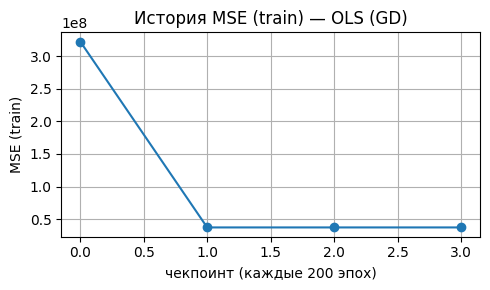

In [8]:
# 2.1 OLS аналитически
w_ols_analytical = ols_normal_equation(X_train_i, y_train)
y_train_pred_ols_analytical = predict(X_train_i, w_ols_analytical)
y_test_pred_ols_analytical = predict(X_test_i, w_ols_analytical)
mse_train_ols_analytical = mse(y_train, y_train_pred_ols_analytical)
mse_test_ols_analytical = mse(y_test, y_test_pred_ols_analytical)

print('OLS (аналитически) — Train MSE:', mse_train_ols_analytical)
print('OLS (аналитически) — Test  MSE:', mse_test_ols_analytical)

# 2.2 OLS численно (градиентный спуск)
w_ols_gd, hist_ols_gd = gradient_descent(
    X_train_i, y_train,
    lr=None, n_epochs=5000,
    l2=0.0, tol=1e-8, verbose=False
)
y_train_pred_ols_gd = predict(X_train_i, w_ols_gd)
y_test_pred_ols_gd = predict(X_test_i, w_ols_gd)
mse_train_ols_gd = mse(y_train, y_train_pred_ols_gd)
mse_test_ols_gd = mse(y_test, y_test_pred_ols_gd)

print('\nOLS (градиентный спуск) — Train MSE:', mse_train_ols_gd)
print('OLS (градиентный спуск) — Test  MSE:', mse_test_ols_gd)

# График истории MSE на train (чекпоинты каждые 200 эпох)
plt.figure(figsize=(5, 3))
plt.plot(hist_ols_gd, marker='o')
plt.title('История MSE (train) — OLS (GD)')
plt.xlabel('чекпоинт (каждые 200 эпох)')
plt.ylabel('MSE (train)')
plt.tight_layout()
plt.show()

## 3. Регуляризация: гребневая регрессия (Ridge) и LASSO

Добавим L2-регуляризацию (Ridge) к модели линейной регрессии:
$$ Q_{L_2}(w) = \|Xw - y\|^2 + \alpha \|w\|_2^2. $$

Найдём веса:
1. **Аналитически** — через формулу \(w^* = (X^T X + \alpha I)^{-1} X^T y\).
2. **Численно** — градиентным спуском с добавлением L2-штрафа.

Параметр регуляризации \(\alpha\) подберём по валидационной выборке (подвыборке train), минимизируя MSE.

Дополнительно покажем LASSO (L1-регуляризацию) с координатным спуском (только численно).

Ridge: лучшая alpha по валидации = 1.333521432163324 , val MSE = 31593653.31551656

Ridge (аналитически) — Train MSE: 37283067.46374783
Ridge (аналитически) — Test  MSE: 33662756.17377119

Ridge (градиентный спуск) — Train MSE: 114474970.03665204
Ridge (градиентный спуск) — Test  MSE: 120722388.65037154


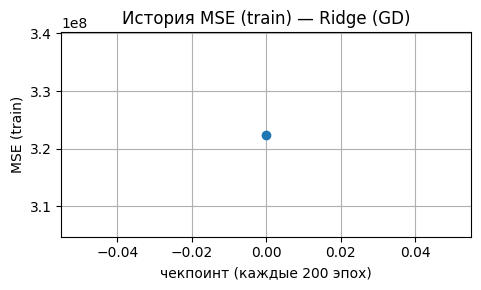


LASSO: лучшая alpha по валидации = 0.001 , val MSE = 31601174.84550993
LASSO (координатный спуск) — Train MSE: 37277681.70208402
LASSO (координатный спуск) — Test  MSE: 33596924.55956214
LASSO занулил 0 из 8 признаков (без учета интерсепта).


In [9]:
# Подбор alpha для Ridge (аналитическое решение) по MSE на валидации
ridge_alphas = np.logspace(-3, 2, 25)  # от 1e-3 до 1e2
best_alpha_ridge, best_val_mse_ridge = ridge_grid_search(X_train_i, y_train, ridge_alphas, val_size=0.2)
print('Ridge: лучшая alpha по валидации =', best_alpha_ridge, ', val MSE =', best_val_mse_ridge)

# Ridge аналитически с лучшей alpha
w_ridge_closed = ridge_closed_form(X_train_i, y_train, best_alpha_ridge)
y_train_pred_ridge_closed = predict(X_train_i, w_ridge_closed)
y_test_pred_ridge_closed = predict(X_test_i, w_ridge_closed)
mse_train_ridge_closed = mse(y_train, y_train_pred_ridge_closed)
mse_test_ridge_closed = mse(y_test, y_test_pred_ridge_closed)

print('\nRidge (аналитически) — Train MSE:', mse_train_ridge_closed)
print('Ridge (аналитически) — Test  MSE:', mse_test_ridge_closed)

# Ridge численно (градиентный спуск с L2)
w_ridge_gd, hist_ridge_gd = gradient_descent(
    X_train_i, y_train,
    lr=None, n_epochs=6000,
    l2=best_alpha_ridge, tol=1e-8, verbose=False
)
y_train_pred_ridge_gd = predict(X_train_i, w_ridge_gd)
y_test_pred_ridge_gd = predict(X_test_i, w_ridge_gd)
mse_train_ridge_gd = mse(y_train, y_train_pred_ridge_gd)
mse_test_ridge_gd = mse(y_test, y_test_pred_ridge_gd)

print('\nRidge (градиентный спуск) — Train MSE:', mse_train_ridge_gd)
print('Ridge (градиентный спуск) — Test  MSE:', mse_test_ridge_gd)

plt.figure(figsize=(5, 3))
plt.plot(hist_ridge_gd, marker='o')
plt.title('История MSE (train) — Ridge (GD)')
plt.xlabel('чекпоинт (каждые 200 эпох)')
plt.ylabel('MSE (train)')
plt.tight_layout()
plt.show()

# LASSO: подбор alpha по валидации и обучение координатным спуском
lasso_alphas = np.logspace(-3, 1, 25)  # от 1e-3 до 1e1
best_alpha_lasso, best_val_mse_lasso = lasso_grid_search(X_train_i, y_train, lasso_alphas, val_size=0.2, n_iters=2000)
print('\nLASSO: лучшая alpha по валидации =', best_alpha_lasso, ', val MSE =', best_val_mse_lasso)

w_lasso = lasso_coordinate_descent(X_train_i, y_train, best_alpha_lasso, n_iters=4000)
y_train_pred_lasso = predict(X_train_i, w_lasso)
y_test_pred_lasso = predict(X_test_i, w_lasso)
mse_train_lasso = mse(y_train, y_train_pred_lasso)
mse_test_lasso = mse(y_test, y_test_pred_lasso)

print('LASSO (координатный спуск) — Train MSE:', mse_train_lasso)
print('LASSO (координатный спуск) — Test  MSE:', mse_test_lasso)

# Сколько весов занулил LASSO (кроме интерсепта)
nonzero = np.count_nonzero(np.abs(w_lasso[1:]) > 1e-9)
print(f'LASSO занулил {len(w_lasso)-1 - nonzero} из {len(w_lasso)-1} признаков (без учета интерсепта).')

## 4. Оценка обобщающей способности моделей

Сравним модели по MSE на **тестовой** выборке:
1. Константная модель — всегда предсказывает среднее значение `charges` по train.
2. Модель OLS (аналитическая и численная версии).
3. Ridge-модель (аналитическая и численная версии), а также LASSO.

Сведём результаты в одну таблицу и посмотрим, какая модель показывает наименьший MSE на тесте.

In [10]:
# Константная модель: прогноз = среднее по train
y_train_mean = float(np.mean(y_train))
y_train_pred_const = np.full_like(y_train, y_train_mean)
y_test_pred_const = np.full_like(y_test, y_train_mean)
mse_train_const = mse(y_train, y_train_pred_const)
mse_test_const = mse(y_test, y_test_pred_const)

results = []
results.append(('Baseline (const mean)', mse_train_const, mse_test_const))
results.append(('OLS analytical', mse_train_ols_analytical, mse_test_ols_analytical))
results.append(('OLS gradient', mse_train_ols_gd, mse_test_ols_gd))
results.append(('Ridge analytical', mse_train_ridge_closed, mse_test_ridge_closed))
results.append(('Ridge gradient', mse_train_ridge_gd, mse_test_ridge_gd))
results.append(('LASSO (CD)', mse_train_lasso, mse_test_lasso))

res_df = pd.DataFrame(results, columns=['Model', 'Train MSE', 'Test MSE']).set_index('Model')
display(res_df.sort_values('Test MSE'))

best_model_by_test = res_df['Test MSE'].idxmin()
print('\nЛучшая модель по MSE на тестовой выборке:', best_model_by_test)
print('её Test MSE =', res_df.loc[best_model_by_test, 'Test MSE'])

,Train MSE,Test MSE
Model,,
OLS analytical,3.727768e+07,3.359692e+07
OLS gradient,3.727768e+07,3.359692e+07
LASSO (CD),3.727768e+07,3.359692e+07
Ridge analytical,3.728307e+07,3.366276e+07
Ridge gradient,1.144750e+08,1.207224e+08
Baseline (const mean),1.443336e+08,1.553914e+08



Лучшая модель по MSE на тестовой выборке: OLS analytical
её Test MSE = 33596915.85136149


## Выводы

- Модель OLS (без регуляризации) даёт базовый уровень качества, но может страдать от нестабильности весов и чувствительности к выбросам.
- Гребневая регрессия (Ridge) добавляет L2-штраф и стабилизирует веса, часто улучшая качество на тестовой выборке.
- LASSO (L1-регуляризация) помимо стабилизации весов может обнулять некоторые коэффициенты, тем самым выполняя отбор признаков.
- Константная модель служит простейшим baseline; корректно построенные регрессионные модели должны показывать существенно меньший MSE на тесте.
- Использование разбиения на train/test (и дополнительной валидации для подбора гиперпараметров) позволяет оценить обобщающую способность моделей и избежать переобучения на всей выборке.